In [1]:
import pandas as pd
import numpy as np
import datetime
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline 
from random import sample
from functools import reduce
import re
import seaborn as sns

In [2]:
path = '../data/'

adjacent_zone = pd.read_csv(path + 'adjacent_zone.csv')
cleaned_trip_df = pd.read_csv(path + 'trip_cleaned.csv')
trip_df = cleaned_trip_df[['hack_license', 'pickup_taxizone_id', 'dropoff_taxizone_id',
                           'pickup_datetime', 'dropoff_datetime']].copy()


### Create adjacent zone dictionary

In [3]:
taxi_zone_list = adjacent_zone['zone1'].unique()
max_taxi_zone = max(trip_df['dropoff_taxizone_id'])
adjacent_zone_dict = {k: np.array([]) for k in range(int(max_taxi_zone+1))}
for z in taxi_zone_list:
    adjacent_zone_dict[z] = adjacent_zone.loc[adjacent_zone['zone1']==z]['zone2'].unique()

### Shift columns to get next PU zone

In [4]:
trip_df.sort_values(['hack_license', 'pickup_datetime'], inplace=True)
trip_df['pickup_datetime_next'] = trip_df.groupby(['hack_license'])['pickup_datetime'].shift(-1)
trip_df['pickup_taxizone_id_next'] = trip_df.groupby(['hack_license'])['pickup_taxizone_id'].shift(-1)


### keep only next PU zones adjacent to or the same as DO zone.

In [5]:
trip_df.dropna(subset = ['pickup_taxizone_id_next'], inplace=True)
trip_df['adjacent_crusing'] = [1 if pu_zone_next in adjacent_zone_dict[do_zone] else 0 \
                               for pu_zone_next, do_zone in \
                               zip(trip_df['pickup_taxizone_id_next'], 
                                   trip_df['dropoff_taxizone_id'])]
trip_df = trip_df.loc[(trip_df['adjacent_crusing'] == 1) |
                      (trip_df['pickup_taxizone_id_next'] == trip_df['dropoff_taxizone_id'])]


In [6]:
trip_df

,hack_license,pickup_taxizone_id,dropoff_taxizone_id,pickup_datetime,dropoff_datetime,pickup_datetime_next,pickup_taxizone_id_next,adjacent_crusing
2,2013000001,142.0,79.0,2013-06-24 19:45:00,2013-06-24 20:10:00,2013-06-24 20:17:00,234.0,1
3,2013000001,234.0,141.0,2013-06-24 20:17:00,2013-06-24 20:28:00,2013-06-24 20:30:00,141.0,0
4,2013000001,141.0,263.0,2013-06-24 20:30:00,2013-06-24 20:35:00,2013-06-24 20:37:00,263.0,0
5,2013000001,263.0,239.0,2013-06-24 20:37:00,2013-06-24 20:49:00,2013-06-24 20:52:00,239.0,0
8,2013000001,162.0,233.0,2013-06-26 17:24:00,2013-06-26 17:35:00,2013-06-26 17:36:00,233.0,0
...,...,...,...,...,...,...,...,...
13885721,2013038799,224.0,224.0,2013-06-30 21:31:35,2013-06-30 21:47:59,2013-06-30 21:59:27,224.0,0
13885722,2013038799,224.0,224.0,2013-06-30 21:59:27,2013-06-30 22:21:20,2013-06-30 22:24:04,224.0,0
13885724,2013038800,137.0,4.0,2013-06-30 18:26:00,2013-06-30 18:41:00,2013-06-30 18:44:00,4.0,0
13885728,2013038800,79.0,137.0,2013-06-30 19:39:00,2013-06-30 19:42:00,2013-06-30 19:45:00,170.0,1


### Compute cruise time

In [7]:
trip_df['pickup_datetime_next'] = pd.to_datetime(trip_df['pickup_datetime_next'])
trip_df['dropoff_datetime'] = pd.to_datetime(trip_df['dropoff_datetime'])

trip_df['cruise_time'] = (trip_df['pickup_datetime_next'] - trip_df['dropoff_datetime'])/np.timedelta64(1, 'm')
trip_df.reset_index(inplace=True)


In [8]:
k = 5
print('Cruise Time less than 0 minutes: {}'.format(trip_df.loc[(trip_df['cruise_time'] < 0)].shape[0]))
print('Cruise Time greater than {} minutes: {}'.format(k*60, trip_df.loc[(trip_df['cruise_time'] >= k*60)].shape[0]))
print('These records are dropped')

Cruise Time less than 0 minutes: 893
Cruise Time greater than 300 minutes: 40589
These records are dropped


### Remove records with cruise time > 300 mins or <0 

In [9]:
trip_df = trip_df.loc[(trip_df['cruise_time'] <= k*60) &
                                        (trip_df['cruise_time'] >= 0)]

# trip_df = trip_df.astype({'cruise_time': 'int32'})

In [10]:
# trip_df.to_csv('../data/trip_df.csv', index=False)

## [aside] Coversion table 

In [11]:
def _generate_one_interval_conversion(interval):
    assert 24*60%interval==0, 'must provide even time interval'
    time_index_list = []
    time_interval_list = []
    time_index_current = 0
    interval_per_day = int(24*60/interval)
    for it in range(interval_per_day):
        minute = (it * interval) % 60 
        hour = (it * interval) // 60 
        time_interval_list.append(datetime.time(hour, minute))
        time_index_list.append(time_index_current)
        time_index_current += 1
    index_col_name = 'time_index_{}m'.format(int(interval))
    interval_index_table = pd.DataFrame({'interval': time_interval_list, 
                                         index_col_name: time_index_list}) 
    return interval_index_table

def generate_interval_conversion(interval_list, file_name=None):
  
    df_list = []
    for it in interval_list:
        df_list.append(_generate_one_interval_conversion(it))
    conv_table = reduce(lambda x, y: pd.merge(x, y, how = "outer", on = 'interval'), 
                        df_list)
    if file_name is not None: 
        conv_table.to_csv(file_name, index=False)
        print('table saved at ', file_name)
    return conv_table

In [12]:
interval = [1, 5, 10, 15, 30, 60]
file_name = path + 'interval_index_table_0.csv'
interval_index_table = generate_interval_conversion(interval, file_name)

table saved at  ../data/interval_index_table_0.csv


In [13]:
interval_index_table

,interval,time_index_1m,time_index_5m,time_index_10m,time_index_15m,time_index_30m,time_index_60m
0,00:00:00,0,0.0,0.0,0.0,0.0,0.0
1,00:01:00,1,NaN,NaN,NaN,NaN,NaN
2,00:02:00,2,NaN,NaN,NaN,NaN,NaN
3,00:03:00,3,NaN,NaN,NaN,NaN,NaN
4,00:04:00,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1435,23:55:00,1435,287.0,NaN,NaN,NaN,NaN
1436,23:56:00,1436,NaN,NaN,NaN,NaN,NaN
1437,23:57:00,1437,NaN,NaN,NaN,NaN,NaN
1438,23:58:00,1438,NaN,NaN,NaN,NaN,NaN


In [14]:
"""
Give df with cruise time columm and an interval conversion table, compute
mean and median of cruise time for certain taxi zone and timestamp. The output
is saved as `cruise_time_{}m.csv`
"""
def compute_cruise_time(trip_df, interval_index_table, file_dir):
    
    ## extract time interval info from interval_index_table
    current_cruise_time_list = []
    index_cols = interval_index_table.columns.values[1:]
    time_index_list = [int(re.search(r'\d+', t).group(0)) for t in index_cols]
    
    for current_i in range(len(index_cols)):
        ## Extract current time interval and column name
        current_index_cols = index_cols[current_i]
        current_time_interval = int(time_index_list[current_i])

        ## round DO time to the same interval
        current_trip_df = trip_df.copy()
        round_by = '{}min'.format(current_time_interval)
        current_trip_df['dropoff_datetime_interval'] = current_trip_df['dropoff_datetime'].dt.round(round_by).dt.time

        ## convert DO interval to time index
        current_conversion = dict(zip(interval_index_table.interval, interval_index_table[current_index_cols]))
        current_trip_df['dropoff_datetime_index'] = [current_conversion[t] for t in current_trip_df['dropoff_datetime_interval']]

        ## Compute med and mean of cruise time
        current_cruise_time = current_trip_df.groupby(['dropoff_datetime_index', 
                                                       'dropoff_datetime_interval', 
                                                       'dropoff_taxizone_id'], as_index=False)['cruise_time'].agg(['mean', 'median', 'count']).reset_index()
        ## round the stat to int
        current_cruise_time['mean'] = [round(t) for t in current_cruise_time['mean']]
        current_cruise_time['median'] = [round(t) for t in current_cruise_time['median']]
        
        ## cast the stat to int
        current_cruise_time = current_cruise_time.astype({'mean': 'int32', 'median': 'int32',
                                                          'dropoff_taxizone_id': 'int32',
                                                          'dropoff_datetime_index': 'int32'})

        ## rename columns
        current_cruise_time.rename(columns = {'dropoff_taxizone_id': 'taxizone_id',
                                          'mean': 'avg_cruise_time'.format(current_time_interval),
                                          'median': 'med_cruise_time'.format(current_time_interval)}, 
                                   inplace=True)
        
        ## Convert stat to interval
        current_cruise_time['avg_cruise_time_INT'] = [t//current_time_interval for t in current_cruise_time['avg_cruise_time']]
        current_cruise_time['med_cruise_time_INT'] = [t//current_time_interval for t in current_cruise_time['med_cruise_time']]


        ## export files
        if file_dir is not None:
            final_file_name = file_dir + 'cruise_time_adjacent_sample_{}m.csv'.format(current_time_interval)
            current_cruise_time.to_csv(final_file_name, index=False)
            print('file saved at ', final_file_name)
        
        current_cruise_time_list.append(current_cruise_time)
        
    return current_cruise_time_list

In [15]:
cruise_time_result = compute_cruise_time(trip_df, interval_index_table, path)

file saved at  ../data/cruise_time_adjacent_sample_1m.csv
file saved at  ../data/cruise_time_adjacent_sample_5m.csv
file saved at  ../data/cruise_time_adjacent_sample_10m.csv
file saved at  ../data/cruise_time_adjacent_sample_15m.csv
file saved at  ../data/cruise_time_adjacent_sample_30m.csv
file saved at  ../data/cruise_time_adjacent_sample_60m.csv


In [16]:
cruise_time_15m = pd.read_csv('../data/cruise_time_15m.csv')

Text(767.7272727272725, 0.5, 'timestamp')

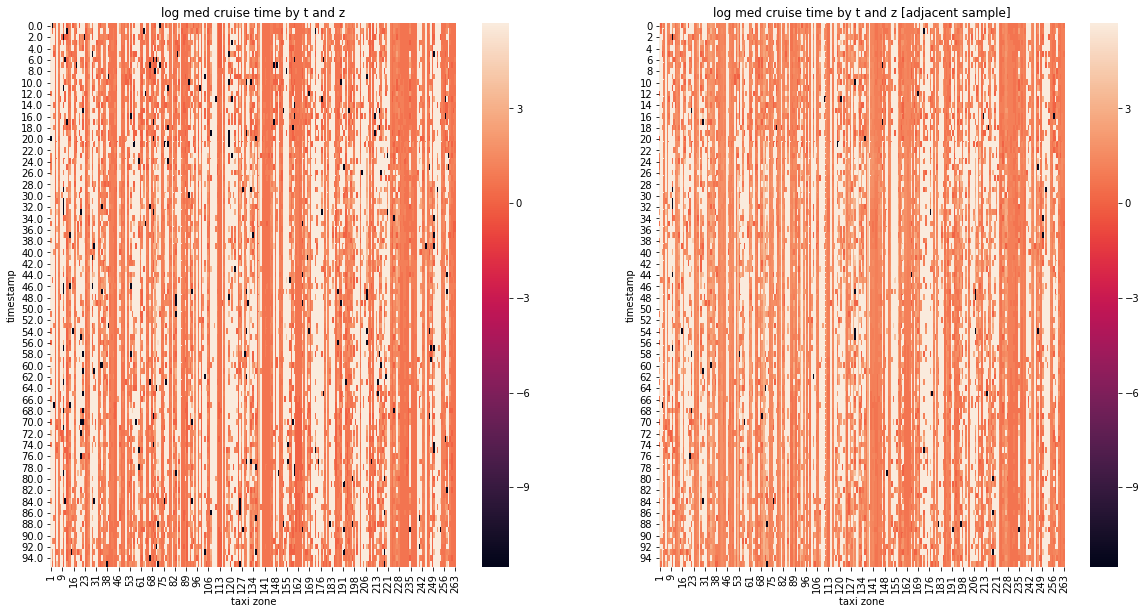

In [17]:
cruise_df = cruise_time_15m.copy()
cruise_df['med_cruise_time'] = np.log(cruise_df['med_cruise_time'] + 1e-5)
cruise_df = cruise_df.pivot_table(index='dropoff_datetime_index', 
                                  columns='taxizone_id', 
                                  values='med_cruise_time')
cruise_df.fillna(np.log(300), inplace=True)

cruise_df_imputed_heatmap = cruise_time_result[3].copy()
cruise_df_imputed_heatmap['med_cruise_time'] = np.log(cruise_df_imputed_heatmap['med_cruise_time'] + 1e-5)
cruise_df_imputed_heatmap = cruise_df_imputed_heatmap\
                        .pivot_table(index='dropoff_datetime_index', 
                                     columns='taxizone_id', 
                                     values='med_cruise_time')
cruise_df_imputed_heatmap.fillna(np.log(300), inplace=True)


fig, ax = plt.subplots(1,2, figsize=(20, 10))
sns.heatmap(cruise_df, ax=ax[0])
ax[0].set_title('log med cruise time by t and z')
ax[0].set_xlabel('taxi zone')
ax[0].set_ylabel('timestamp')

sns.heatmap(cruise_df_imputed_heatmap, ax=ax[1])
ax[1].set_title('log med cruise time by t and z [adjacent sample]')
ax[1].set_xlabel('taxi zone')
ax[1].set_ylabel('timestamp')
# fig.savefig('../heatmap_cruise_time.png')

## ====